<a href="https://colab.research.google.com/github/badbloody/diploma2023/blob/main/Situation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 导入必要的库

In [3]:
!pip install tensorboardX
!pip install horovod

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import requests
import os
import shutil
import zipfile

# getting the COCO dataset
def download_and_extract_coco(dataset_dir, number_of_images):
    # download annotations
    annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    annotations_path = "/content/coco_dataset/annotations.zip"

    # create a directory for the dataset
    os.makedirs(dataset_dir, exist_ok=True)

    # download annotations zip file
    print("Downloading annotations...")
    response = requests.get(annotations_url, stream=True)
    with open(annotations_path, "wb") as file:
        shutil.copyfileobj(response.raw, file)

    # extract annotations
    print("Extracting annotations...")
    with zipfile.ZipFile(annotations_path, "r") as zip_ref:
        zip_ref.extractall(dataset_dir)

    # download images
    images_url = "http://images.cocodataset.org/zips/train2017.zip"
    images_path = "/content/coco_dataset/images.zip"

    # Download images zip file
    print("Downloading images...")
    response = requests.get(images_url, stream=True)
    with open(images_path, "wb") as file:
        shutil.copyfileobj(response.raw, file)

    # extracting images
    print("Extracting images...")
    with zipfile.ZipFile(images_path, "r") as zip_ref:
        # extracting only the specified number of images
        selected_images = zip_ref.infolist()[:number_of_images]
        zip_ref.extractall(dataset_dir, members=selected_images)

    # removing the files afterwards
    os.remove(annotations_path)
    os.remove(images_path)

# the number of images we want to download and where
number_of_images= 10000
dataset_dir = "/content/coco_dataset"
download_and_extract_coco(dataset_dir, number_of_images)

Extracting annotations...
Extracting images...


In [ ]:
%cp -av "/content/coco_dataset" "/content/gdrive/MyDrive/coco_dataset"

In [5]:
import random
import requests
import os
import shutil
import zipfile

# helper function that splits the dataset into training and validation subsets
def split_dataset(dataset_dir, train_dir, val_dir, train_ratio):
    # Create directories for train and validation sets
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get the list of files in the dataset directory
    files = os.listdir(dataset_dir)
    random.shuffle(files)

    # Calculate the number of files for training and validation
    total_files = len(files)
    train_count = int(train_ratio * total_files)
    val_count = total_files - train_count

    # Move files to the train and validation directories
    for i, file in enumerate(files):
        src_path = os.path.join(dataset_dir, file)
        if i < train_count:
            dst_path = os.path.join(train_dir, file)
        else:
            dst_path = os.path.join(val_dir, file)
        shutil.move(src_path, dst_path) #move from source to destination path

    print("Dataset split into train and validation sets.")

In [6]:
content_dataset_dir = "/content/gdrive/MyDrive/coco_dataset/coco_dataset/train2017"
desired_train_dir = "/content/gdrive/MyDrive/coco_train"
desired_val_dir = "/content/gdrive/MyDrive/coco_val"
desired_train_ratio = 0.8

#split_dataset(content_dataset_dir, desired_train_dir, desired_val_dir, desired_train_ratio)

In [ ]:
print(len(os.listdir(desired_train_dir)))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
tensor_normalizer = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
epsilon = 1e-5

def preprocess_image(image, target_width=None):
    """输入 PIL.Image 对象，输出标准化后的四维 tensor"""
    if target_width:
        t = transforms.Compose([
            transforms.Resize(target_width),
            transforms.CenterCrop(target_width),
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    else:
        t = transforms.Compose([
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    return t(image).unsqueeze(0)


def image_to_tensor(image, target_width=None):
    """输入 OpenCV 图像，范围 0~255，BGR 顺序，输出标准化后的四维 tensor"""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return preprocess_image(image, target_width)


def read_image(path, target_width=None):
    """输入图像路径，输出标准化后的四维 tensor"""
    image = Image.open(path)
    return preprocess_image(image, target_width)


def recover_image(tensor):
    """输入 GPU 上的四维 tensor，输出 0~255 范围的三维 numpy 矩阵，RGB 顺序"""
    image = tensor.detach().cpu().numpy()
    image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]


def recover_tensor(tensor):
    m = torch.tensor(cnn_normalization_mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(cnn_normalization_std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m
    return tensor.clamp(0, 1)


def imshow(tensor, title=None):
    """输入 GPU 上的四维 tensor，然后绘制该图像"""
    image = recover_image(tensor)
    print(image.shape)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


def mean_std(features):
    """输入 VGG16 计算的四个特征，输出每张特征图的均值和标准差，长度为1920"""
    mean_std_features = []
    for x in features:
        x = x.view(*x.shape[:2], -1)
        x = torch.cat([x.mean(-1), torch.sqrt(x.var(-1) + epsilon)], dim=-1)
        n = x.shape[0]
        x2 = x.view(n, 2, -1).transpose(2, 1).contiguous().view(n, -1) # 【mean, ..., std, ...] to [mean, std, ...]
        mean_std_features.append(x2)
    mean_std_features = torch.cat(mean_std_features, dim=-1)
    return mean_std_features


class Smooth:
    # 对输入的数据进行滑动平均
    def __init__(self, windowsize=100):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 1), dtype=np.float32)
        self.index = 0

    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

    def __float__(self):
        return float(self.data.mean())

    def __format__(self, f):
        return self.__float__().__format__(f)

In [8]:
#os.mkdir("/content/styleImages")
dataset_dir = "/content/gdrive/MyDrive/diplomskiSlike/styleImages/portraits"
train_dir = "/content/styleImages/train"
val_dir = "/content/styleImages/val"
train_ratio = 0.8  # 80% train, 20% validation

split_dataset(dataset_dir, train_dir, val_dir, train_ratio)

Dataset split into train and validation sets.


In [9]:
width = 256
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(width, scale=(256/480, 1), ratio=(1, 1)),
    transforms.ToTensor(),
    tensor_normalizer
])

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
%rm -rf diplomskiSlike
!git clone https://github.com/badbloody/diplomskiSlike

width = 256
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(width, scale=(256/480, 1), ratio=(1, 1)),
    transforms.ToTensor(),
    tensor_normalizer
])

%rm -rf styleImages #delete if there is a folder from the previuous session

#current_dir = 'diplomskiSlike/portraits' #define which style images you want here (either portraits, abstractLiquify or sketches)
#style_dir = '/content/styleImages'

#processed_style_dir = os.path.join(style_dir, "train")
#os.makedirs(processed_style_dir, exist_ok=True)

#for filename in os.listdir(current_dir):
#  shutil.copy2(os.path.join(current_dir, filename), processed_style_dir)

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#style_dataset = torchvision.datasets.ImageFolder(root=style_dir, transform=data_transform)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 29.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for horovod: filename=horovod-0.28.1-cp310-cp310-linux_x86_64.whl size=37729156 sha256=0e0ad6da215181d0d23346d2852f89705aa57e82aa1a3ddf995544c1637d4ce5
  Stored in directory: /root/.cache/pip/wheels/68/48/5f/ebbf9b83e04c68070cf9621e6466c33d698efb747d7920b81f
Successfully built horovod


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from collections import defaultdict

#from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class VGG(nn.Module):

    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs


class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(MyConv2D, self).__init__()
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = torch.zeros(out_channels).to(device)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        return s.format(**self.__dict__)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1),
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x


def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1,
    upsample=None, instance_norm=True, relu=True, trainable=False):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    if trainable:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    else:
        layers.append(MyConv2D(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers


class TransformNet(nn.Module):
    def __init__(self, base=8):
        super(TransformNet, self).__init__()
        self.base = base
        self.weights = []
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9, trainable=True),
            *ConvLayer(base, base*2, kernel_size=3, stride=2),
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2),
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False, trainable=True),
        )
        self.get_param_dict()

    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

    def get_param_dict(self):
        """找出该网络所有 MyConv2D 层，计算它们需要的权值数量"""
        param_dict = defaultdict(int)
        def dfs(module, name):
            for name2, layer in module.named_children():
                dfs(layer, '%s.%s' % (name, name2) if name != '' else name2)
            if module.__class__ == MyConv2D:
                param_dict[name] += int(np.prod(module.weight.shape))
                param_dict[name] += int(np.prod(module.bias.shape))
        dfs(self, '')
        return param_dict

    def set_my_attr(self, name, value):
        # 下面这个循环是一步步遍历类似 residuals.0.conv.1 的字符串，找到相应的权值
        target = self
        for x in name.split('.'):
            if x.isnumeric():
                target = target.__getitem__(int(x))
            else:
                target = getattr(target, x)

        # 设置对应的权值
        n_weight = np.prod(target.weight.shape)
        target.weight = value[:n_weight].view(target.weight.shape)
        target.bias = value[n_weight:].view(target.bias.shape)

    def set_weights(self, weights, i=0):
        """输入权值字典，对该网络所有的 MyConv2D 层设置权值"""
        for name, param in weights.items():
            self.set_my_attr(name, weights[name][i])


class MetaNet(nn.Module):
    def __init__(self, param_dict):
        super(MetaNet, self).__init__()
        self.param_num = len(param_dict)
        self.hidden = nn.Linear(1920, 128*self.param_num)
        self.fc_dict = {}
        for i, (name, params) in enumerate(param_dict.items()):
            self.fc_dict[name] = i
            setattr(self, 'fc{}'.format(i+1), nn.Linear(128, params))

    def forward(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters


In [11]:
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import shutil
from glob import glob

from tensorboardX import SummaryWriter

import numpy as np
import multiprocessing

import copy
from tqdm import tqdm
from collections import defaultdict

import horovod.torch as hvd
import torch.utils.data.distributed

#from utils import *
#from models import *
import time

from pprint import pprint
display = pprint

hvd.init()
#torch.cuda.set_device(hvd.local_rank())

device = torch.device("cuda:%s" %hvd.local_rank() if torch.cuda.is_available() else "cpu")

In [13]:
is_hvd = False
tag = 'nohvd'
base = 32
style_weight = 50
content_weight = 1
tv_weight = 1e-6
epochs = 22

batch_size = 8
width = 256

verbose_hist_batch = 100
verbose_image_batch = 800
#verbose_image_batch=10
model_name = f'metanet_base{base}_style{style_weight}_tv{tv_weight}_tag{tag}'
print(f'model_name: {model_name}, rank: {hvd.rank()}')

model_name: metanet_base32_style50_tv1e-06_tagnohvd, rank: 0


In [14]:
def rmrf(path):
    try:
        shutil.rmtree(path)
    except:
        pass

for f in glob('gdrive/MyDrive/runs/*/.AppleDouble'):
    rmrf(f)

rmrf('gdrive/MyDrive/runs/' + model_name)

# 搭建模型

In [15]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
transform_net = TransformNet(base).to(device)
transform_net.get_param_dict()

defaultdict(int,
            {'downsampling.5': 18496,
             'downsampling.9': 73856,
             'residuals.0.conv.1': 147584,
             'residuals.0.conv.5': 147584,
             'residuals.1.conv.1': 147584,
             'residuals.1.conv.5': 147584,
             'residuals.2.conv.1': 147584,
             'residuals.2.conv.5': 147584,
             'residuals.3.conv.1': 147584,
             'residuals.3.conv.5': 147584,
             'residuals.4.conv.1': 147584,
             'residuals.4.conv.5': 147584,
             'upsampling.2': 73792,
             'upsampling.7': 18464})

In [17]:
metanet = MetaNet(transform_net.get_param_dict()).to(device)

# 载入数据集

> During training, each content image or style image is resized to keep the smallest dimension in the range [256, 480], and randomly cropped regions of size 256 × 256.

## 载入 COCO 数据集和 WikiArt 数据集

> The batch size of content images is 8 and the meta network is trained for 20 iterations before changing the style image.

In [ ]:
%rm -rf styleImages #delete if there is a folder from the previuous session

In [18]:
style_path = "/content/styleImages/train"

style_contents = os.path.join("/content/styleTraining", "train")
os.makedirs(style_contents, exist_ok=True)

# Copy images to the processed directory
for filename in os.listdir(style_path):
    shutil.copy2(os.path.join(style_path, filename), style_contents)


# Load the processed dataset using ImageFolder
style_dataset = torchvision.datasets.ImageFolder(root="/content/styleTraining", transform=data_transform)

In [ ]:
content_contents = os.path.join("/content/gdrive/MyDrive/contentTraining", "train")
os.makedirs(content_contents, exist_ok=True)

# Copy images to the processed directory

content_path = "/content/gdrive/MyDrive/coco_train"
for filename in os.listdir(content_path):
    shutil.copy2(os.path.join(content_path, filename), content_contents)


content_dataset = torchvision.datasets.ImageFolder(root="/content/gdrive/MyDrive/contentTraining", transform=data_transform)

In [19]:
content_dataset = torchvision.datasets.ImageFolder(root="/content/gdrive/MyDrive/contentTraining", transform=data_transform)

In [20]:
if is_hvd:
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        content_dataset, num_replicas=hvd.size(), rank=hvd.rank())
    content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size,
        num_workers=multiprocessing.cpu_count(),sampler=train_sampler)
else:
    content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size,
        shuffle=True, num_workers=multiprocessing.cpu_count())

if not is_hvd or hvd.rank() == 0:
    print(style_dataset)
    print('-'*20)
    print(content_dataset)

Dataset ImageFolder
    Number of datapoints: 11
    Root location: /content/styleTraining
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
--------------------
Dataset ImageFolder
    Number of datapoints: 9621
    Root location: /content/gdrive/MyDrive/contentTraining
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# 测试 infer

In [21]:
metanet.eval()
transform_net.eval()

rands = torch.rand(4, 3, 256, 256).to(device)
features = vgg16(rands);
weights = metanet(mean_std(features));
transform_net.set_weights(weights)
transformed_images = transform_net(torch.rand(4, 3, 256, 256).to(device));

if not is_hvd or hvd.rank() == 0:
    print('features:')
    display([x.shape for x in features])

    print('weights:')
    display([x.shape for x in weights.values()])

    print('transformed_images:')
    display(transformed_images.shape)

features:
[torch.Size([4, 64, 256, 256]),
 torch.Size([4, 128, 128, 128]),
 torch.Size([4, 256, 64, 64]),
 torch.Size([4, 512, 32, 32])]
weights:
[torch.Size([4, 18496]),
 torch.Size([4, 73856]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 147584]),
 torch.Size([4, 73792]),
 torch.Size([4, 18464])]
transformed_images:
torch.Size([4, 3, 256, 256])


# 初始化一些变量

In [22]:
visualization_style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
visualization_content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)

In [ ]:
if not is_hvd or hvd.rank() == 0:
    for f in glob('gdrive/MyDrive/runs/*/.AppleDouble'):
        rmrf(f)

    rmrf('runs/' + model_name)
    writer = SummaryWriter('gdrive/MyDrive/runs/'+model_name)
else:
    writer = SummaryWriter('gdrive/MyDrive/tmp/'+model_name)

visualization_style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
visualization_content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)

writer.add_images('content_image', recover_tensor(visualization_content_images), 0)
writer.add_graph(transform_net, (rands, ))

del rands, features, weights, transformed_images

In [25]:
trainable_params = {}
trainable_param_shapes = {}
for model in [vgg16, transform_net, metanet]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params[name] = param
            trainable_param_shapes[name] = param.shape

# 开始训练

In [26]:
optimizer = optim.Adam(trainable_params.values(), 1e-3)

if is_hvd:
    optimizer = hvd.DistributedOptimizer(optimizer,
                                         named_parameters=trainable_params.items())
    params = transform_net.state_dict()
    params.update(metanet.state_dict())
    hvd.broadcast_parameters(params, root_rank=0)

In [ ]:
import os

os.mkdir('/content/gdrive/MyDrive/checkpoints')
os.mkdir('/content/gdrive/MyDrive/models')

In [27]:
n_batch = len(content_data_loader)
metanet.train()
transform_net.train()

for epoch in range(epochs):
    smoother = defaultdict(Smooth)
    with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            n_iter = epoch*n_batch + batch

            # 每 20 个 batch 随机挑选一张新的风格图像，计算其特征
            if batch % 20 == 0:
                style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
                style_features = vgg16(style_image)
                style_mean_std = mean_std(style_features)

            # 检查纯色
            x = content_images.cpu().numpy()
            if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
                continue

            optimizer.zero_grad()

            # 使用风格图像生成风格模型
            weights = metanet(mean_std(style_features))
            transform_net.set_weights(weights, 0)

            # 使用风格模型预测风格迁移图像
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)

            # 使用 vgg16 计算特征
            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)
            transformed_mean_std = mean_std(transformed_features)

            # content loss
            content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

            # style loss
            style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                                  style_mean_std.expand_as(transformed_mean_std))

            # total variation loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                    torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            # 求和
            loss = content_loss + style_loss + tv_loss

            loss.backward()
            optimizer.step()

            smoother['content_loss'] += content_loss.item()
            smoother['style_loss'] += style_loss.item()
            smoother['tv_loss'] += tv_loss.item()
            smoother['loss'] += loss.item()

            max_value = max([x.max().item() for x in weights.values()])

            writer.add_scalar('loss/loss', loss, n_iter)
            writer.add_scalar('loss/content_loss', content_loss, n_iter)
            writer.add_scalar('loss/style_loss', style_loss, n_iter)
            writer.add_scalar('loss/total_variation', tv_loss, n_iter)
            writer.add_scalar('loss/max', max_value, n_iter)

            s = 'Epoch: {} '.format(epoch+1)
            s += 'Content: {:.2f} '.format(smoother['content_loss'])
            s += 'Style: {:.1f} '.format(smoother['style_loss'])
            s += 'Loss: {:.2f} '.format(smoother['loss'])
            s += 'Max: {:.2f}'.format(max_value)

            if (batch + 1) % verbose_image_batch == 0:
                transform_net.eval()
                visualization_transformed_images = transform_net(visualization_content_images)
                transform_net.train()
                visualization_transformed_images = torch.cat([style_image, visualization_transformed_images])
                writer.add_images('debug', recover_tensor(visualization_transformed_images), n_iter)
                del visualization_transformed_images

            if (batch + 1) % verbose_hist_batch == 0:
                for name, param in weights.items():
                    writer.add_histogram('transform_net.'+name, param.clone().cpu().data.numpy(),
                                        n_iter, bins='auto')

                for name, param in transform_net.named_parameters():
                    writer.add_histogram('transform_net.'+name, param.clone().cpu().data.numpy(),
                                        n_iter, bins='auto')

                for name, param in metanet.named_parameters():
                    l = name.split('.')
                    l.remove(l[-1])
                    writer.add_histogram('metanet.'+'.'.join(l), param.clone().cpu().data.numpy(),
                                        n_iter, bins='auto')

            pbar.set_description(s)

            del transformed_images, weights

    if not is_hvd or hvd.rank() == 0:
        torch.save(metanet.state_dict(), '/content/gdrive/MyDrive/checkpoints/{}_{}.pth'.format(model_name, epoch+1))
        torch.save(transform_net.state_dict(),
                  '/content/gdrive/MyDrive/checkpoints/{}_transform_net_{}.pth'.format(model_name, epoch+1))

        torch.save(metanet.state_dict(), '/content/gdrive/MyDrive/models/{}.pth'.format(model_name))
        torch.save(transform_net.state_dict(), '/content/gdrive/MyDrive/models/{}_transform_net.pth'.format(model_name))

Epoch: 1 Content: 20.38 Style: 39.3 Loss: 60.01 Max: 142.67: 100%|██████████| 1203/1203 [12:41<00:00,  1.58it/s]
Epoch: 2 Content: 18.28 Style: 25.5 Loss: 44.11 Max: 423.01: 100%|██████████| 1203/1203 [12:24<00:00,  1.62it/s]
Epoch: 3 Content: 19.82 Style: 30.5 Loss: 50.75 Max: 347.06: 100%|██████████| 1203/1203 [12:24<00:00,  1.62it/s]
Epoch: 4 Content: 17.12 Style: 25.6 Loss: 43.04 Max: 211.26: 100%|██████████| 1203/1203 [12:29<00:00,  1.61it/s]
Epoch: 5 Content: 19.21 Style: 27.4 Loss: 47.04 Max: 637.97: 100%|██████████| 1203/1203 [12:29<00:00,  1.61it/s]
Epoch: 6 Content: 18.79 Style: 22.4 Loss: 41.65 Max: 977.92: 100%|██████████| 1203/1203 [12:25<00:00,  1.61it/s]
Epoch: 7 Content: 15.12 Style: 13.8 Loss: 29.17 Max: 479.78: 100%|██████████| 1203/1203 [12:29<00:00,  1.60it/s]
Epoch: 8 Content: 16.49 Style: 15.3 Loss: 32.21 Max: 1362.82: 100%|██████████| 1203/1203 [12:33<00:00,  1.60it/s]
Epoch: 9 Content: 15.00 Style: 13.7 Loss: 29.06 Max: 1487.76: 100%|██████████| 1203/1203 [12:36

FileNotFoundError: ignored

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


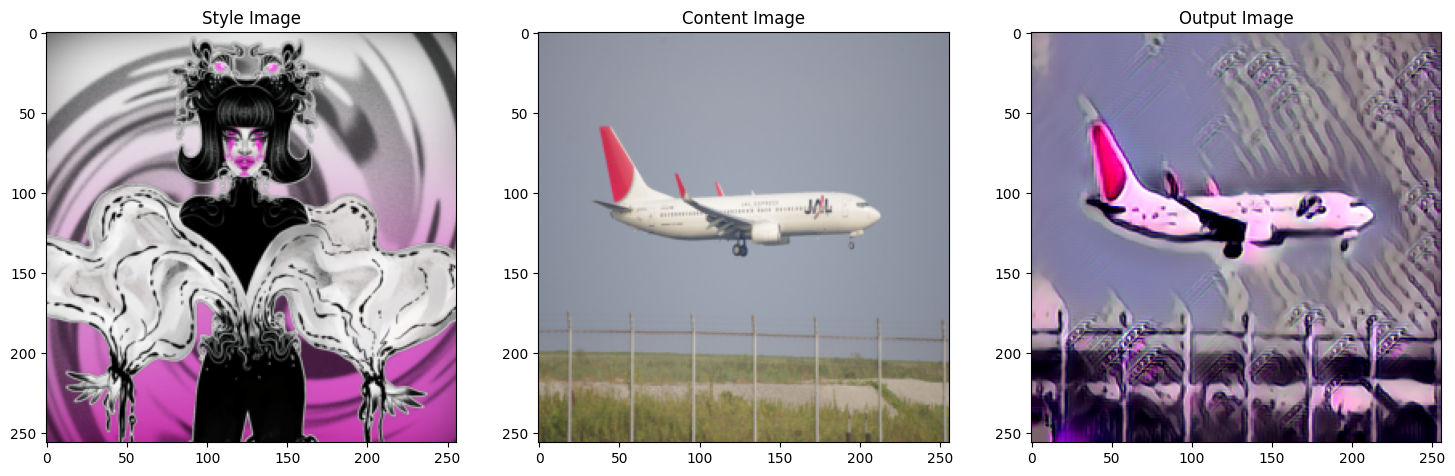

In [28]:
content_img = random.choice(content_dataset)[0].unsqueeze(0).to(device)
output_img = transform_net(content_img)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
imshow(style_image, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
imshow(output_img.detach(), title='Output Image')